In [1]:
import math as mth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.stats import linregress
from datetime import datetime, timedelta
import random
import sys
import os
import json # library to handle JSON files
from matplotlib import cm,colors
from matplotlib.colors import Normalize
from geopy.geocoders import Nominatim # convert an place into latitude and longitude values
import folium # map rendering library
from bs4 import BeautifulSoup
import camelot
import requests
from IPython import get_ipython

In [2]:
import warnings

# Customize how warnings are displayed
warnings.filterwarnings('always', module='.*')
warnings.formatwarning = lambda message, category, filename, lineno, line=None: f'{category.__name__}: {message}\n'

General Classes and Functions

In [3]:
# Class to create Plots grid

from itertools import product,cycle,combinations
import seaborn as sns
import matplotlib.pyplot as plt

class Plotsgrid:

    """ Creates a nxn grid of plots for an input df. Shows blank for grid values exceeding number of columns of df"""


    def __init__(self,df):
        self.df=df 

    def figure_params(self):
        df=self.df
        n_data_cols=len(df.columns)
        self.n_data_cols=n_data_cols 

        n_cols=int(n_data_cols**.5)
        n_rows=0
        while n_rows*n_cols<n_data_cols:
            n_rows+=1
        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(int(2.5*n_data_cols),int(2*n_rows)))
        
        # Flatten the axs array for easier iteration
        self.axs = axs.flatten()

    # Loop through the axes and Hist plot
    def histplots(self,bins=-1):
        # Initialize figure 
        self.figure_params()
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            if bins==-1:
                sns.histplot(data=self.df, x=col, ax=ax)  # Plot the histogram on the current axis
            else:
                sns.histplot(data=self.df, x=col, ax=ax,bins=bins)  # Plot the histogram on the current axis
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Box plot
    def boxplots(self):
        # Initialize figure 
        self.figure_params()
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            try:
                if i==self.n_data_cols:
                    ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                    break
                col = next(cycler)  # Get the next column name
                sns.boxplot(data=self.df, x=col, ax=ax)  # Plot the boxplot on the current axis
            except Exception as E:
                print(E)
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Line plot
    def lineplots(self):
        # Initialize figure 
        self.figure_params()
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            sns.lineplot(data=self.df,x=self.df.index,y=col, ax=ax)  # Plot the Line on the current axis
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Scatter plot for each combination of columns
    def scatterplots(self):
        # Create a cycler to iterate over the DataFrame columns
        col_combs = list(combinations(self.df.columns, r=2))
        num_combs = len(col_combs)

        # Initialize figure 
        n_cols = int(num_combs ** .5)
        n_rows = 0
        while n_rows * n_cols < num_combs:
            n_rows += 1
        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(int(2.5 * num_combs), int(6 * n_rows)))
        
        # Flatten the axs array for easier iteration
        axs = axs.flatten()
        for i, (ax, (xval, yval)) in enumerate(zip(axs, col_combs)):
            if i == len(col_combs):
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            
            # Plot the scatter plot
            df=self.df.dropna(subset=[xval,yval])
            sns.scatterplot(data=df, x=xval, y=yval, ax=ax)  # Plot the scatter plot on the current axis

            # Perform linear regression to calculate slope and R^2
            slope, intercept, r_value, p_value, std_err = linregress(df[xval], df[yval])

            # Annotate the plot with slope and R^2
            ax.text(0.05, 0.95, f'Slope: {slope:.2f}\n$R^2$: {r_value**2:.2f}', 
                    transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="black"))

        plt.tight_layout()
        plt.show()


### Air Quality by City

In [4]:
# Air quality by City
filename = 'AQI_Bulletin_20240820.xlsx'
sheet='Table 1'

df_aqi = pd.read_excel(filename)

Pre-processing

In [5]:
df_aqi.shape

(237, 9)

In [6]:
# Print the first few rows
df_aqi.head()

,S.No,City,Unnamed: 2,Unnamed: 3,Air Quality,Unnamed: 5,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
0,1,Agartala,NaN,NaN,Good,NaN,36,PM10,1/2
1,2,Agra,NaN,NaN,Good,NaN,31,"SO2, NO2, PM10",6/6
2,3,Ahmedabad,NaN,NaN,Satisfactory,NaN,75,"PM2.5, PM10",8/9
3,4,Ahmednagar,NaN,NaN,Good,NaN,38,PM10,1/1
4,5,Aizawl,NaN,NaN,Good,NaN,22,O3,1/1


In [7]:
df_aqi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   S.No                                          229 non-null    object
 1   City                                          228 non-null    object
 2   Unnamed: 2                                    7 non-null      object
 3   Unnamed: 3                                    7 non-null      object
 4   Air Quality                                   229 non-null    object
 5   Unnamed: 5                                    7 non-null      object
 6   Index Value                                   228 non-null    object
 7   Prominent Pollutant                           228 non-null    object
 8   No. of Stations Participated/ Total Stations  228 non-null    object
dtypes: object(9)
memory usage: 16.8+ KB


In [8]:
# Drop null values from Index Value
df_aqi.dropna(subset=['Index Value']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 228 entries, 0 to 227
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   S.No                                          228 non-null    object
 1   City                                          228 non-null    object
 2   Unnamed: 2                                    0 non-null      object
 3   Unnamed: 3                                    0 non-null      object
 4   Air Quality                                   228 non-null    object
 5   Unnamed: 5                                    0 non-null      object
 6   Index Value                                   228 non-null    object
 7   Prominent Pollutant                           228 non-null    object
 8   No. of Stations Participated/ Total Stations  228 non-null    object
dtypes: object(9)
memory usage: 17.8+ KB


We are only interested in numeric types for Index Value. Trying to coerce the dtype for the column to numeric creates an exception due to some of the values being string. We can explore what the string values are

In [9]:
# Print unique string values
df_aqi['Index Value'].apply(lambda x:x if type(x)==str else '').unique()

array(['', 'Index Value'], dtype=object)

Looks like 'Index Value' is the non-numeric field. Let's print rows of this value

In [10]:
df_aqi[df_aqi['Index Value']=='Index Value']

,S.No,City,Unnamed: 2,Unnamed: 3,Air Quality,Unnamed: 5,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
20,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
41,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
62,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
83,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
104,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
125,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
146,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
167,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
188,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
209,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations


Gives us also bad values for 'City', 'Air Quality', 'Prominent Pollutant' and 'No. of Stations Participated/ Total Stations'. So we can drop the rows corresponding to 'Index Value'

In [11]:
df_aqi=df_aqi[df_aqi['Index Value']!='Index Value']
# Check for nan values in index value
df_aqi[df_aqi['Index Value'].isna()]

,S.No,City,Unnamed: 2,Unnamed: 3,Air Quality,Unnamed: 5,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
228,Cities absent in AQI Bulletin due to insuffici...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,NaN,NaN,AQI,Category,Color Code,Possible Health Impacts,NaN,NaN,NaN
231,NaN,NaN,0-50,Good,NaN,Minimal Impact,NaN,NaN,NaN
232,NaN,NaN,51-100,Satisfactory,NaN,Minor breathing discomfort to sensitive people,NaN,NaN,NaN
233,NaN,NaN,101-200,Moderate,NaN,"Breathing discomfort to the people with lungs,...",NaN,NaN,NaN
234,NaN,NaN,201-300,Poor,NaN,Breathing discomfort to most people on prolong...,NaN,NaN,NaN
235,NaN,NaN,301-400,Very Poor,NaN,Respiratory illness on prolonged exposure,NaN,NaN,NaN
236,NaN,NaN,401-500,Severe,NaN,Affects healthy people and seriously impacts t...,NaN,NaN,NaN


In [12]:
# It is safe to drop the rows that have NAN index value
df_aqi=df_aqi.dropna(subset=['Index Value'])
# try to coerce df_aqi index value to numeric
df_aqi['Index Value']=df_aqi['Index Value'].astype(int)

In [13]:
# Print info and stats
df_aqi['Index Value'].describe()

count    218.000000
mean      56.958716
std       21.772243
min       11.000000
25%       42.000000
50%       54.000000
75%       67.750000
max      141.000000
Name: Index Value, dtype: float64

Lets explore the columns again

In [14]:
# Print the info
df_aqi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218 entries, 0 to 227
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   S.No                                          218 non-null    object
 1   City                                          218 non-null    object
 2   Unnamed: 2                                    0 non-null      object
 3   Unnamed: 3                                    0 non-null      object
 4   Air Quality                                   218 non-null    object
 5   Unnamed: 5                                    0 non-null      object
 6   Index Value                                   218 non-null    int32 
 7   Prominent Pollutant                           218 non-null    object
 8   No. of Stations Participated/ Total Stations  218 non-null    object
dtypes: int32(1), object(8)
memory usage: 16.2+ KB


In [15]:
# First few rows again
df_aqi.head()

,S.No,City,Unnamed: 2,Unnamed: 3,Air Quality,Unnamed: 5,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
0,1,Agartala,NaN,NaN,Good,NaN,36,PM10,1/2
1,2,Agra,NaN,NaN,Good,NaN,31,"SO2, NO2, PM10",6/6
2,3,Ahmedabad,NaN,NaN,Satisfactory,NaN,75,"PM2.5, PM10",8/9
3,4,Ahmednagar,NaN,NaN,Good,NaN,38,PM10,1/1
4,5,Aizawl,NaN,NaN,Good,NaN,22,O3,1/1


Looks like removing nans from index value removed a lot of the bad data from other columns as well, including City. For our purposes we only need the 'City' and Index Value.

In [16]:
df_aqi_city_index=df_aqi[['City','Index Value']]

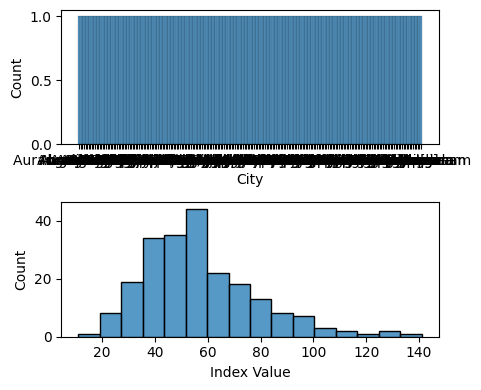

In [17]:
# Hist Plots
Plotsgrid(df_aqi_city_index).histplots()

Create Geolocator using Nominatim and Obtain Location info. for the places

In [18]:
geoagent="explorer"
geolocator = Nominatim(user_agent=geoagent)
lat_list=[]
lon_list=[]
cities=df_aqi_city_index.City.tolist()
for city in cities:
    try:
        loc = geolocator.geocode(city)
        lat_list.append(loc.latitude)
        lon_list.append(loc.longitude)
    except Exception as E:
        print(E)
        lat_list.append(np.nan)
        lon_list.append(np.nan)
        
df_aqi_city_index['latitude']=lat_list
df_aqi_city_index['longitude']=lon_list



'NoneType' object has no attribute 'latitude'
'NoneType' object has no attribute 'latitude'
'NoneType' object has no attribute 'latitude'
'NoneType' object has no attribute 'latitude'


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
# Explore nan atitude and longitudes
df_aqi_city_index[(df_aqi_city_index['latitude'].isna())|(df_aqi_city_index['longitude'].isna())]

,City,Index Value,latitude,longitude
49,Bileipada,81,NaN,NaN
136,Kunjemura,71,NaN,NaN
164,Palkalaiperur,11,NaN,NaN
204,Suakati,32,NaN,NaN


There are just four cities with no location information. We can drop these

In [20]:
df_aqi_city_index=df_aqi_city_index[(df_aqi_city_index['latitude'].isna()==False)&(df_aqi_city_index['longitude'].isna()==False)].reset_index(drop=True)

In [21]:
df_aqi_city_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         214 non-null    object 
 1   Index Value  214 non-null    int32  
 2   latitude     214 non-null    float64
 3   longitude    214 non-null    float64
dtypes: float64(2), int32(1), object(1)
memory usage: 6.0+ KB


In [22]:
df_aqi_city_index.head()

,City,Index Value,latitude,longitude
0,Agartala,36,23.831238,91.282382
1,Agra,31,27.175255,78.009816
2,Ahmedabad,75,23.021537,72.580057
3,Ahmednagar,38,19.162773,74.858024
4,Aizawl,22,23.743353,92.738276


In [23]:
# Location for country
country='India'
country_loc=geolocator.geocode(country)
latitude=country_loc.latitude
longitude=country_loc.longitude
latitude,longitude

(22.3511148, 78.6677428)

In [24]:
# Rename some columns:
df_aqi_city_index.rename(columns={'Index Value':'City AQI Value','latitude':'City latitude','longitude':'City longitude'},inplace=True)

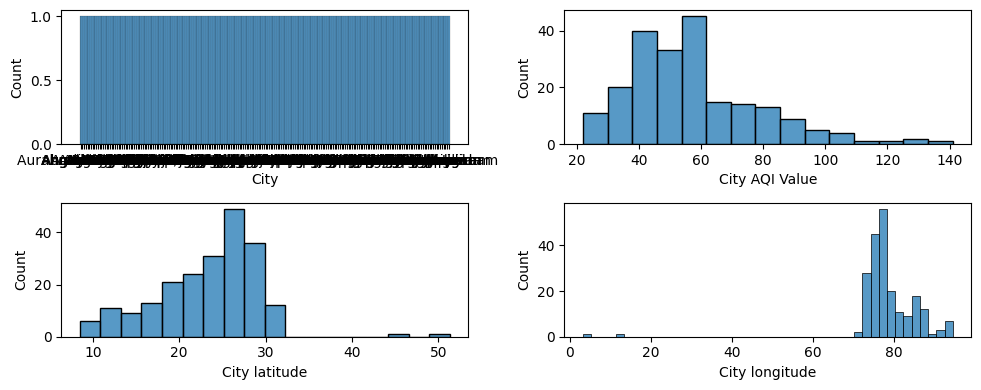

In [52]:
# Histograms
Plotsgrid(df_aqi_city_index).histplots()

Plot on Map

In [25]:
maps={}
map_clusters = folium.Map(location=[latitude, longitude],zoom_start=5)

# Define a colormap using matplotlib
colormap = plt.get_cmap('YlOrRd')  # You can choose any colormap from matplotlib

# Normalize index values to range [0, 1] for the colormap
norm = Normalize(vmin=df_aqi_city_index['City AQI Value'].min(), vmax=df_aqi_city_index['City AQI Value'].max())

# add markers to the map
markers_colors = []

for index,row in df_aqi_city_index.iterrows():

    name,index_val,lat,lon=row['City'],row['City AQI Value'],row['City latitude'],row['City longitude']
    label = folium.Popup(f"{name}, Index Value: {index_val}", parse_html=True)

    # Get color from colormap
    rgba_color = colormap(norm(index_val))  # This returns an RGBA tuple
    hex_color = colors.rgb2hex(rgba_color[:3])  # Convert to hex

    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=hex_color,
        fill=True,
        fill_color=hex_color,
        fill_opacity=0.7,
                        ).add_to(map_clusters)

map_clusters


<b> Observations: </b>
<li> The highest AQI (maximum pollution) occurs in the North west and towards the east.
<li> Southern cities have in general better AQI

## Import Population information

In [26]:
population_url='https://www.godigit.com/explore/city-list/list-of-cities-in-india'
df_pop_list=pd.read_html(population_url)
for frame in df_pop_list:
    print(frame.head())


                  0            1          2                               3
0  Name of the City        State       Area  Population (Subject to Change)
1            Mumbai  Maharashtra  603.4 km²                        21297000
2             Delhi        Delhi  1,483 km²                        32941000
3         Bangalore    Karnataka    741 km²                        13608000
4         Hyderabad    Telangana    650 km²                        10801000
                  0               1        2                               3
0  Name of the City           State     Area  Population (Subject to Change)
1          Amritsar          Punjab  139 km²                         1452000
2            Bhopal  Madhya Pradesh  463 km²                         2565000
3       Bhubaneswar          Odisha  422 km²                         1258000
4        Chandigarh      Chandigarh  114 km2                         1215000
                  0               1          2                               3
0  

In [27]:
# Create the population dataframe from the pop df
df_pop=pd.DataFrame()
for frame in df_pop_list:
    df_pop=pd.concat([df_pop,frame],axis=0)
df_pop.head()

,0,1,2,3
0,Name of the City,State,Area,Population (Subject to Change)
1,Mumbai,Maharashtra,603.4 km²,21297000
2,Delhi,Delhi,"1,483 km²",32941000
3,Bangalore,Karnataka,741 km²,13608000
4,Hyderabad,Telangana,650 km²,10801000


In [28]:
# Make the first row as header
df_pop.columns=df_pop.iloc[0,:]
df_pop=df_pop[1:]
df_pop.head()

,Name of the City,State,Area,Population (Subject to Change)
1,Mumbai,Maharashtra,603.4 km²,21297000
2,Delhi,Delhi,"1,483 km²",32941000
3,Bangalore,Karnataka,741 km²,13608000
4,Hyderabad,Telangana,650 km²,10801000
5,Ahmedabad,Gujarat,505 km²,8650605


In [32]:
# Rename 'Population (Subject to Change)' to 'City Population' and 'Name of the City' to 'City'
df_pop.rename(columns={'Name of the City':'City','Population (Subject to Change)':'City Population','Area':'City Area'},inplace=True)

In [33]:
df_pop.head()

,City,State,City Area,City Population
1,Mumbai,Maharashtra,603.4 km²,21297000
2,Delhi,Delhi,"1,483 km²",32941000
3,Bangalore,Karnataka,741 km²,13608000
4,Hyderabad,Telangana,650 km²,10801000
5,Ahmedabad,Gujarat,505 km²,8650605


In [34]:
# Remove 'km2' from Area
df_pop['City Area']=df_pop['City Area'].str.replace(' km²','').str.replace(',','')
df_pop['City Area'].head()

1    603.4
2     1483
3      741
4      650
5      505
Name: City Area, dtype: object

In [35]:
# Print unique string values
df_pop['City Area'].apply(lambda x:x if type(x)==str else '').unique()

array(['603.4', '1483', '741', '650', '505', '426', '206.1', 'Area',
       '139', '463', '422', '114 km2', '189.9', '210', '224', '467',
       '94.88', '631', '393.5', '250', '226', '461.6', '640', '121', '55',
       '260', '286.2', '294', '2311', '102', '44.50', '3385', '19.54',
       '1745', '72.41', '326', '160', '37', '124', '147.99', '61.88',
       '450', '270', '192.5', '264.2', '5037 km2', '8.28', '15', '2959',
       '19.2', '29.21', '304.05 km2', '22.18', '796.81', '64'],
      dtype=object)

In [36]:
# Replace km2 with ''
df_pop['City Area']=df_pop['City Area'].str.replace(' km2','')
# Print unique string values
df_pop['City Area'].apply(lambda x:x if type(x)==str else '').unique()

array(['603.4', '1483', '741', '650', '505', '426', '206.1', 'Area',
       '139', '463', '422', '114', '189.9', '210', '224', '467', '94.88',
       '631', '393.5', '250', '226', '461.6', '640', '121', '55', '260',
       '286.2', '294', '2311', '102', '44.50', '3385', '19.54', '1745',
       '72.41', '326', '160', '37', '124', '147.99', '61.88', '450',
       '270', '192.5', '264.2', '5037', '8.28', '15', '2959', '19.2',
       '29.21', '304.05', '22.18', '796.81', '64'], dtype=object)

In [37]:
# Look at the 'City Area' rows
df_pop[df_pop['City Area']=='City Area']

,City,State,City Area,City Population


In [39]:
# Drop these rows
df_pop=df_pop[df_pop['City Area']!='Area']
df_pop['City Area']=df_pop['City Area'].astype(float)
df_pop['City Area'].head()

1     603.4
2    1483.0
3     741.0
4     650.0
5     505.0
Name: City Area, dtype: float64

In [40]:
df_pop.head()

,City,State,City Area,City Population
1,Mumbai,Maharashtra,603.4,21297000
2,Delhi,Delhi,1483.0,32941000
3,Bangalore,Karnataka,741.0,13608000
4,Hyderabad,Telangana,650.0,10801000
5,Ahmedabad,Gujarat,505.0,8650605


In [41]:
df_pop[['City Area','City Population']]=df_pop[['City Area','City Population']].astype(float)
df_pop[['City Area','City Population']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, 1 to 10
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   City Area        55 non-null     float64
 1   City Population  55 non-null     float64
dtypes: float64(2)
memory usage: 1.3 KB


In [42]:
# Create a population density (Population/Area)
df_pop['Population Density']=df_pop['City Population']/df_pop['City Area']
df_pop.head()

,City,State,City Area,City Population,Population Density
1,Mumbai,Maharashtra,603.4,21297000.0,35294.995028
2,Delhi,Delhi,1483.0,32941000.0,22212.407283
3,Bangalore,Karnataka,741.0,13608000.0,18364.372470
4,Hyderabad,Telangana,650.0,10801000.0,16616.923077
5,Ahmedabad,Gujarat,505.0,8650605.0,17129.910891


## Factory Information

In [43]:
fac_filename='india_factory.csv'
df_fac=pd.read_csv(fac_filename)
df_fac.head()

,Sr. No,State/Union Territory,On register at the beginning of the year,Newly registered during the year,Removed from the register during the year,On Register at the end of the year,Working on any day during the year,Submitting returns,Percentage Response
0,1,A. & N. Islands,48,6,6,42,42,26,61.90
1,2,Andhra Pradesh,25292,1632,1665,25259,19326,5448,28.19
2,3,Assam,6945,296,16,7225,6133,286,4.66
3,4,Bihar,7972,160,3,8129,6170,102,12.80
4,5,Chandigarh,413,7,1,412,412,52,12.62


We are more interested in the 'State/Union Terrtory' and 'On Register at the end of year'. First lets convert these column names to something more readable

In [44]:
df_fac.rename(columns={'State/Union Territory':'State','Working on any day during the year':'Num of Factories in State'},inplace=True)
df_fac=df_fac[['State','Num of Factories in State']]
df_fac.head()

,State,Num of Factories in State
0,A. & N. Islands,42
1,Andhra Pradesh,19326
2,Assam,6133
3,Bihar,6170
4,Chandigarh,412


## Combine the AQI, Population and Factories information

We can combine Population and factories info on state, then the combined table with AQI on city.

In [45]:
# 'State' values for population and factories information
print(sorted(df_pop.State.unique().tolist()))
print(sorted(df_fac.State.unique().tolist()))

['Andhra Pradesh', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Delhi', 'Gujarat', 'Haryana', 'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh', 'West Bengal']
['A. & N. Islands', 'Andhra Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Daman & Diu and Dadra & Nagar Haveli', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand', 'Kerala', 'Manipur', 'Meghalaya', 'Nagaland', 'Puducherry', 'Rajasthan', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttarakhand']


In [46]:
df_pop_fac=df_pop.merge(df_fac,on='State',how='outer')
df_pop_fac

,City,State,City Area,City Population,Population Density,Num of Factories in State
0,NaN,A. & N. Islands,NaN,NaN,NaN,42.0
1,Visakhapatnam,Andhra Pradesh,640.00,2331000.0,3642.187500,19326.0
2,Rajahmundry,Andhra Pradesh,44.50,470000.0,10561.797753,19326.0
3,Vijayawada,Andhra Pradesh,61.88,2230000.0,36037.491920,19326.0
4,Chilakaluripet,Andhra Pradesh,15.00,138000.0,9200.000000,19326.0
...,...,...,...,...,...,...
62,Kasganj,Uttar Pradesh,22.18,138000.0,6221.821461,NaN
63,NaN,Uttarakhand,NaN,NaN,NaN,3403.0
64,Kolkata,West Bengal,206.10,15332793.0,74394.919942,NaN
65,Bhadreswar,West Bengal,8.28,121662.0,14693.478261,NaN


In [47]:
# Merge the AQI and pop_fac tables
df=df_pop_fac.merge(df_aqi_city_index,on='City',how='right')
df

,City,State,City Area,City Population,Population Density,Num of Factories in State,City AQI Value,City latitude,City longitude
0,Agartala,NaN,NaN,NaN,NaN,NaN,36,23.831238,91.282382
1,Agra,Uttar Pradesh,121.00,2368000.0,19570.247934,NaN,31,27.175255,78.009816
2,Ahmedabad,Gujarat,505.00,8650605.0,17129.910891,35339.0,75,23.021537,72.580057
3,Ahmednagar,NaN,NaN,NaN,NaN,NaN,38,19.162773,74.858024
4,Aizawl,NaN,NaN,NaN,NaN,NaN,22,23.743353,92.738276
...,...,...,...,...,...,...,...,...,...
209,Vijayawada,Andhra Pradesh,61.88,2230000.0,36037.491920,19326.0,54,16.508757,80.618509
210,Virar,NaN,NaN,NaN,NaN,NaN,85,19.449800,72.812061
211,Visakhapatnam,Andhra Pradesh,640.00,2331000.0,3642.187500,19326.0,63,17.723128,83.301284
212,Vrindavan,NaN,NaN,NaN,NaN,NaN,83,27.575373,77.693804


In [48]:
# Make another column for State averaged AQI to compare AQI with state level info

# Group by 'State' and calculate the average of 'Index Value' (AQI)
state_avg_aqi = df.groupby('State')['City AQI Value'].mean().reset_index()

# Rename the column for clarity
state_avg_aqi.columns = ['State', 'State_Avg_AQI']

# Merge the state-level average AQI back into the original DataFrame
df=pd.merge(df, state_avg_aqi, on='State', how='left')

# Display the updated DataFrame
df.head()

,City,State,City Area,City Population,Population Density,Num of Factories in State,City AQI Value,City latitude,City longitude,State_Avg_AQI
0,Agartala,NaN,NaN,NaN,NaN,NaN,36,23.831238,91.282382,NaN
1,Agra,Uttar Pradesh,121.0,2368000.0,19570.247934,NaN,31,27.175255,78.009816,52.166667
2,Ahmedabad,Gujarat,505.0,8650605.0,17129.910891,35339.0,75,23.021537,72.580057,67.666667
3,Ahmednagar,NaN,NaN,NaN,NaN,NaN,38,19.162773,74.858024,NaN
4,Aizawl,NaN,NaN,NaN,NaN,NaN,22,23.743353,92.738276,NaN


Make plots

In [ ]:
# Numeric columns
df_numeric=df.select_dtypes(include=['number'])

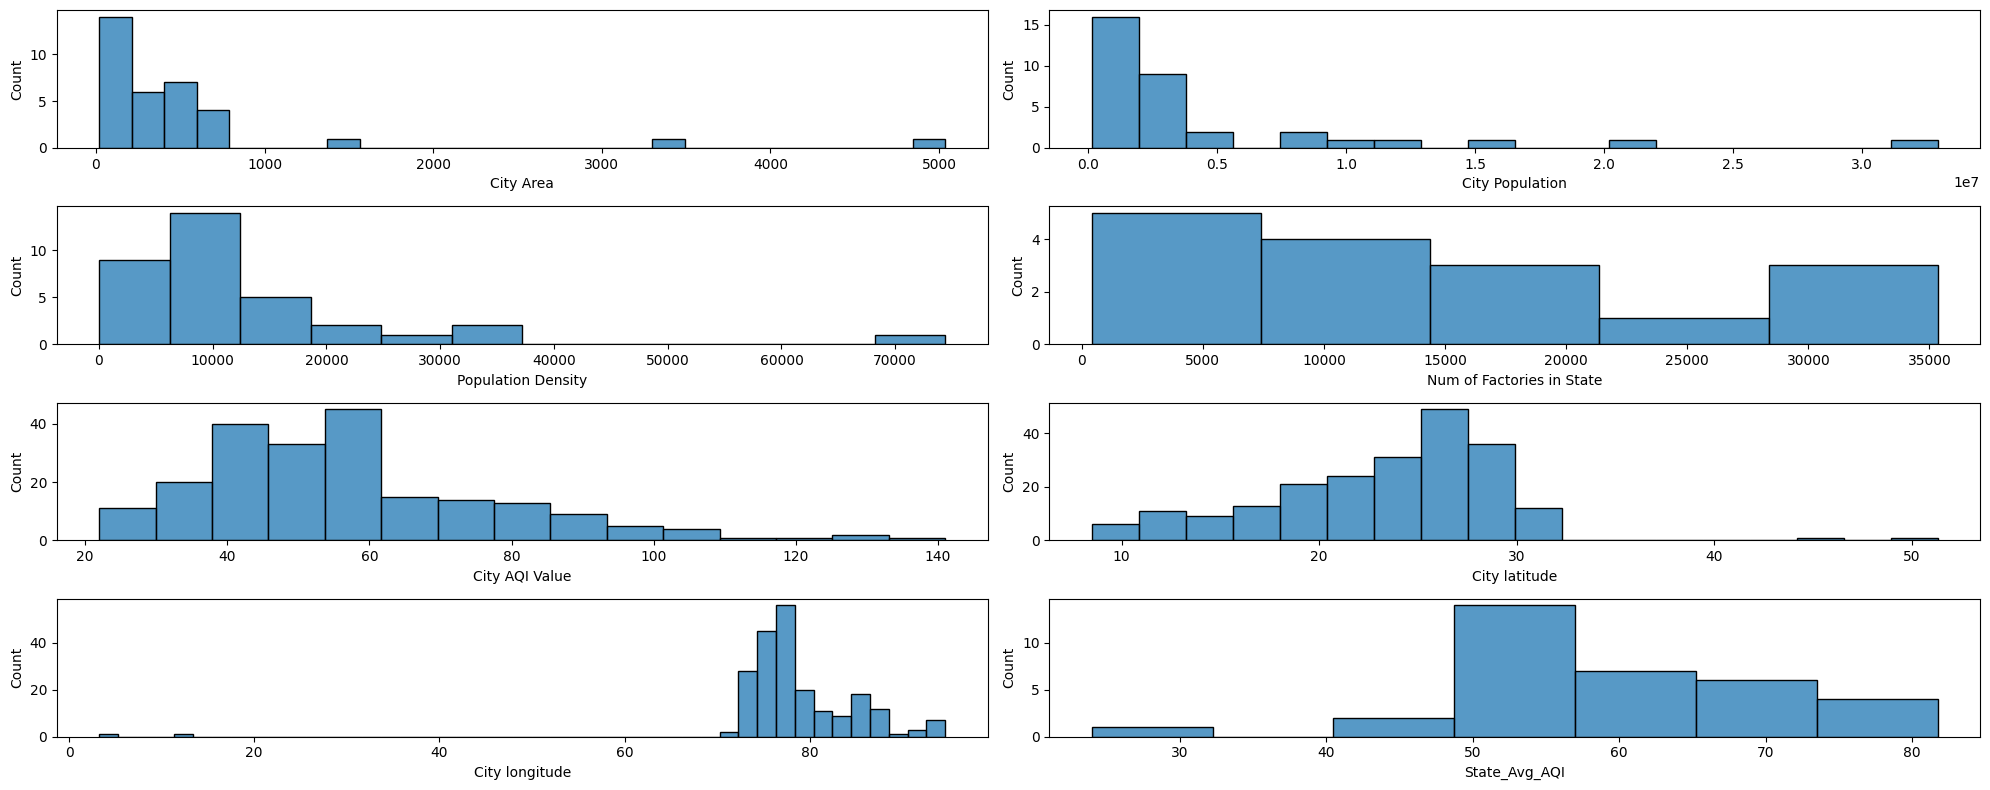

In [51]:
# Hist Plots
Plotsgrid(df_numeric).histplots()

<li> State Average AQI has an almost normal distribution, suggesting that good or bad AQI is not characteristic of the state as a whole, but is more a regional city-level characteristic

<Axes: >

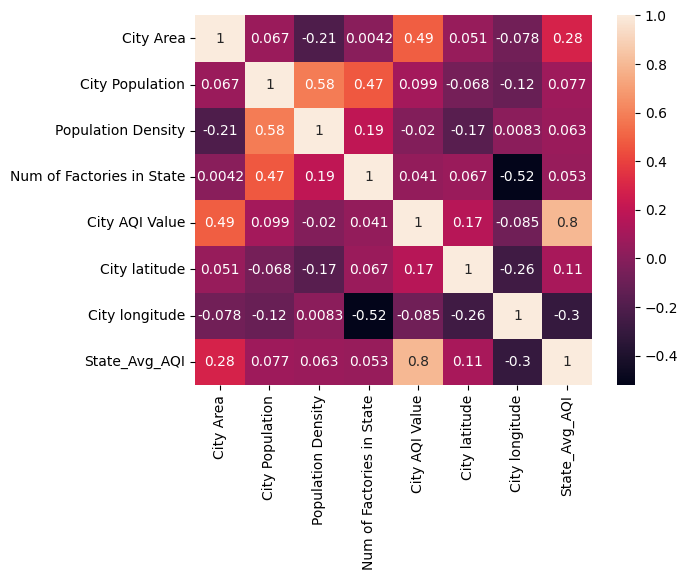

In [49]:
# Correlation Plot
sns.heatmap(df_numeric.corr(),annot=True)

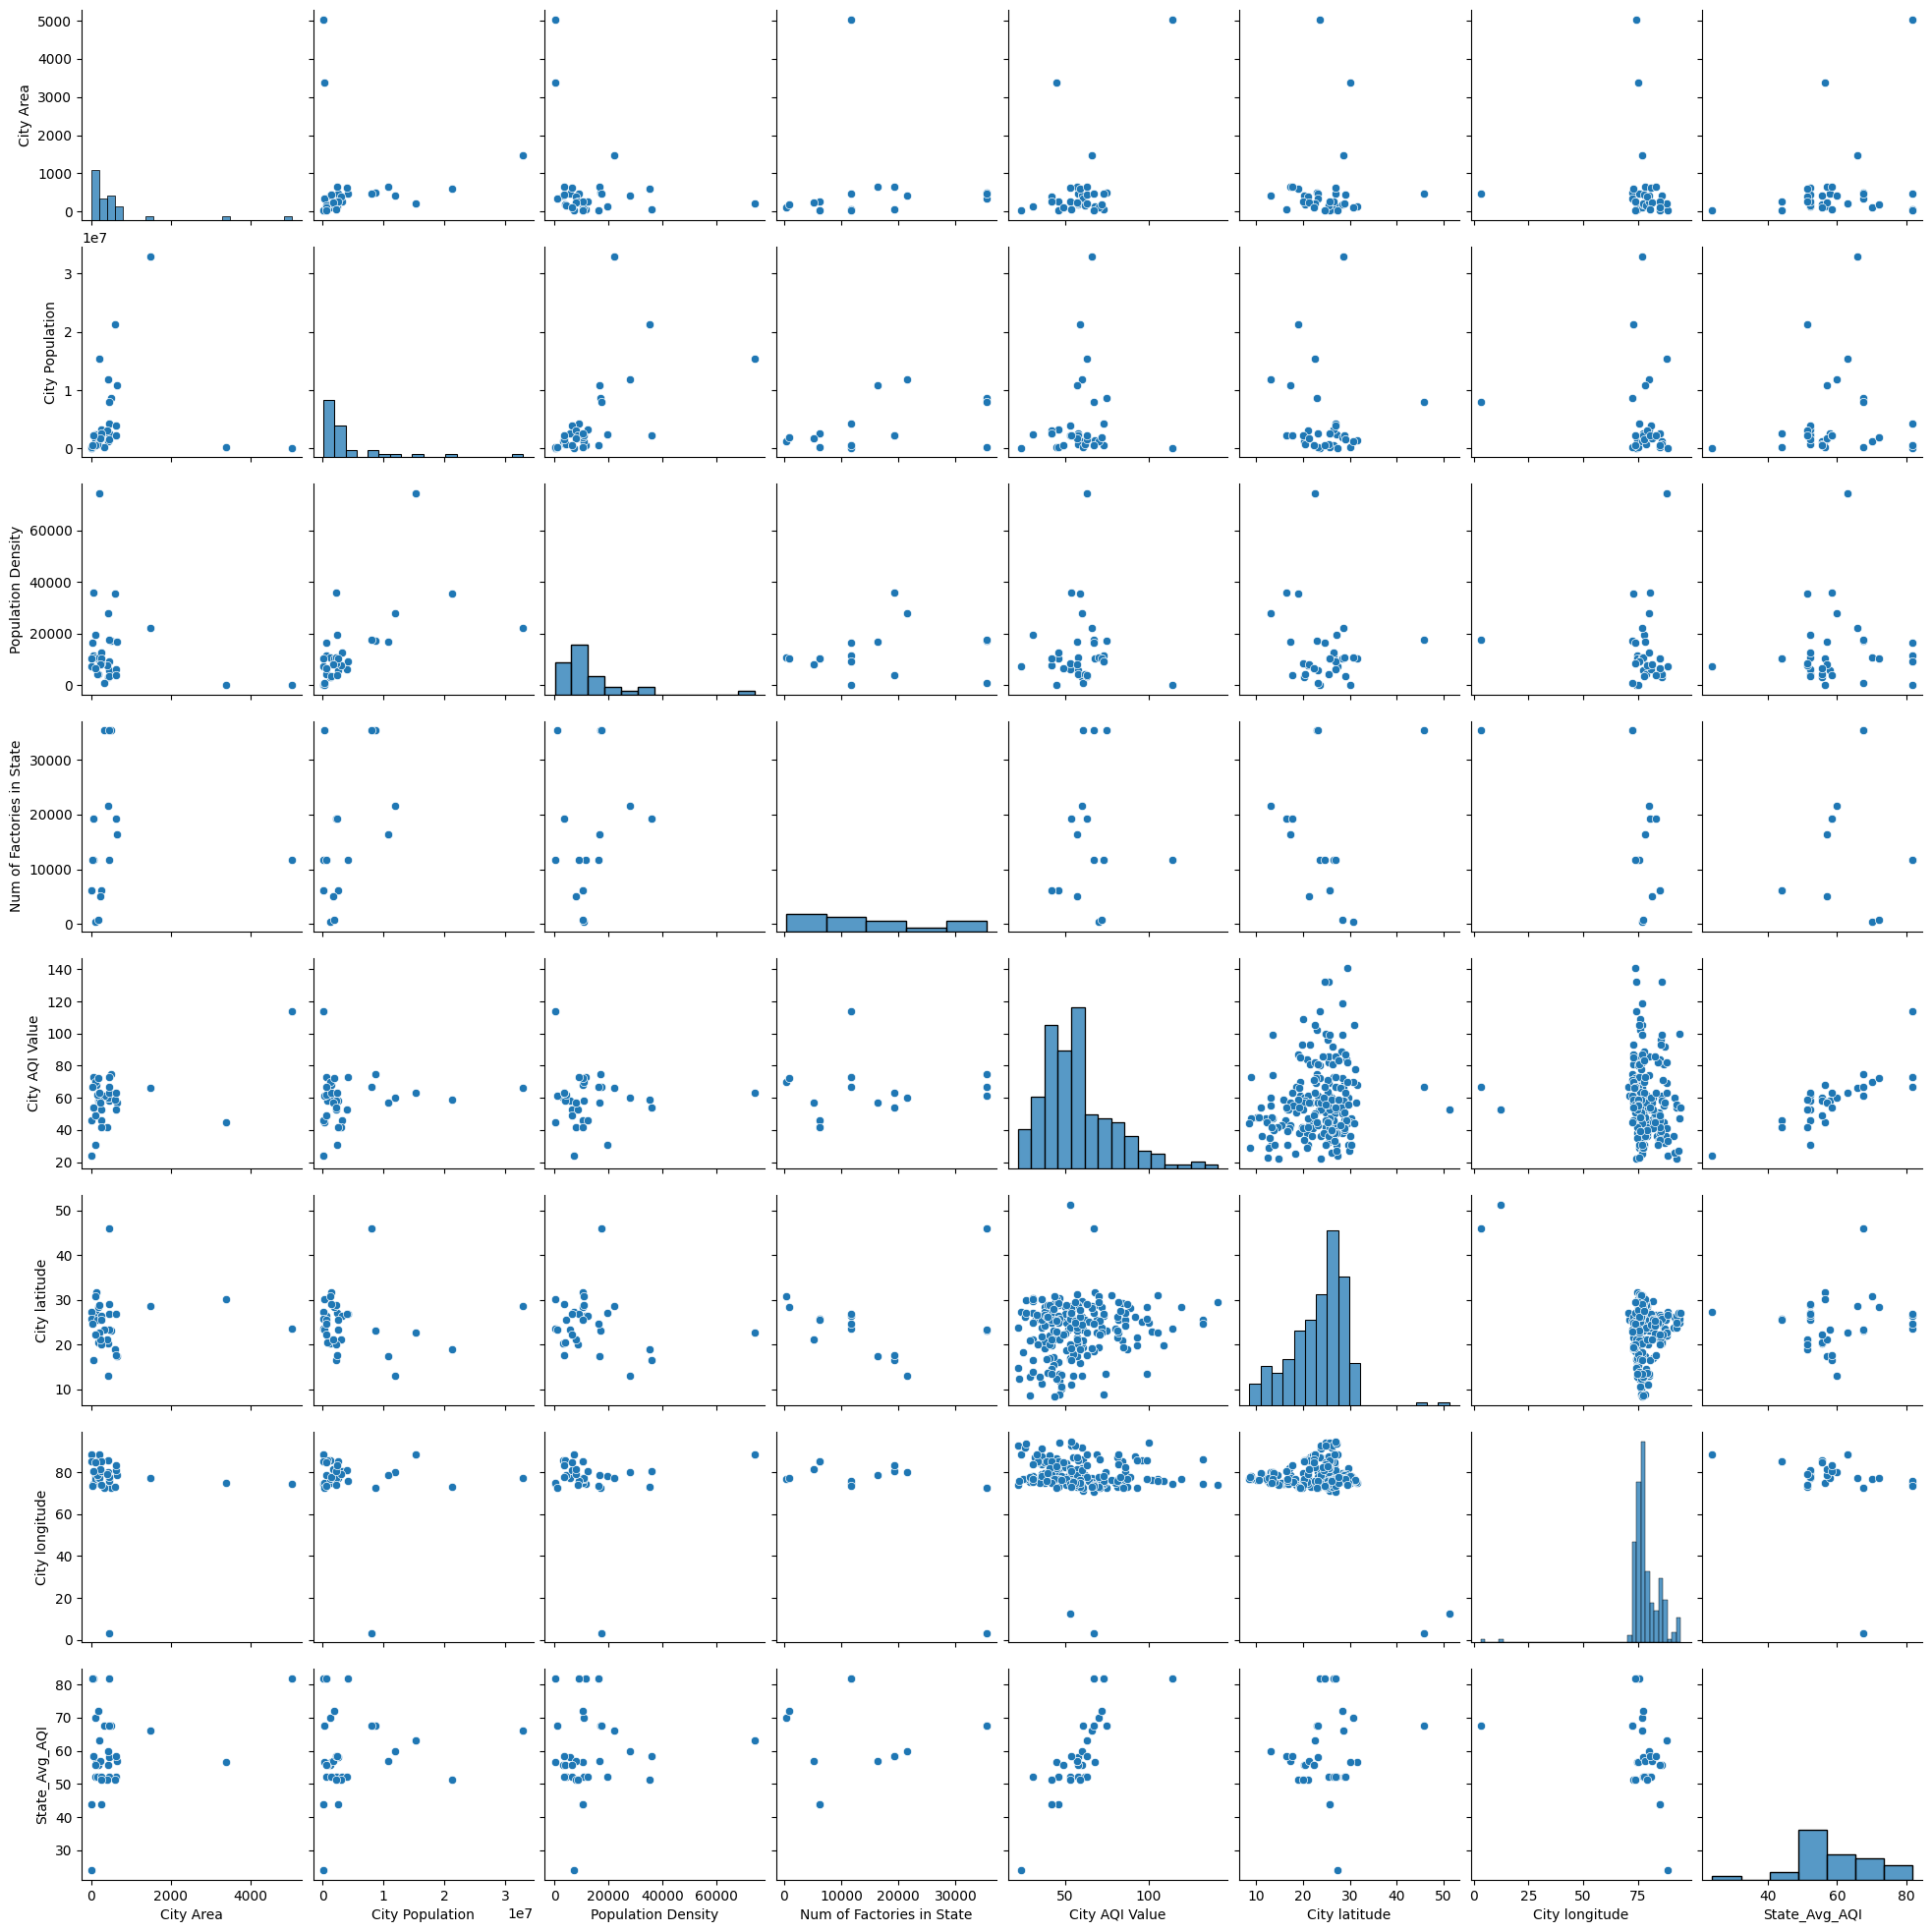

In [50]:
sns.pairplot(df)

<b> Concluding Remarks </b>
<li>The strongest correlations are found between Index Value and: Population, Area, latitude, longitude. Especially Area which has R2 of .24, followed by latitude (.03).
<li>This also ties into how we observed southern areas of India to have better Air quality (lower AQI)
<li> The reason for Area having such a high impact on City AQI but not Population, or Population Density, is not clear
<li>Population Density and Number of factories were not seen to have a significant impact on AQI
<li> Other factors that can be looked at include outdoor burning, motor vehicles, electric/hybrid vehicles, economic information
